In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy import stats

In [228]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

**RETAIL WINE & SPIRITS INVENTORY OPTIMIZATION ANALYSIS**

SECTION 1: BUSINESS UNDERSTANDING & KPI DEFINITIONS

In [229]:
BUSINESS_OBJECTIVES = {
    'primary': 'Optimize inventory levels to minimize carrying costs while maintaining service levels',
    'secondary': [
        'Reduce stockout incidents',
        'Identify slow-moving and obsolete inventory',
        'Improve supplier lead time reliability',
        'Optimize reorder quantities and timing'
    ]
}

In [230]:
KPIS = {
    'Inventory Turnover': 'Cost of Goods Sold / Average Inventory Value',
    'Days of Inventory': '(Average Inventory / COGS) × 365',
    'Stockout Rate': '% of SKU-days with zero inventory',
    'Fill Rate': '% of demand met from stock',
    'Carrying Cost %': '% of inventory value (assumed 20-25% annually)',
    'Service Level': 'Target 95% (probability of not stocking out during lead time)'
}

In [231]:
ASSUMPTIONS = {
    'carrying_cost_rate': 0.22,  # 22% annual carrying cost
    'ordering_cost': 50,  # $50 per order (typical retail)
    'service_level': 0.95,  # 95% service level target
    'lead_time_days': 7,  # Default 7-day lead time if not calculable
    'safety_stock_z': 1.65,  # Z-score for 95% service level
    'seasonality_period': 52,  # Weekly seasonality
    'min_history_weeks': 12  # Minimum weeks for demand forecasting
}

In [232]:
print(f"\nBusiness Objective: {BUSINESS_OBJECTIVES['primary']}")
print(f"\nKey Assumptions:")
for key, value in ASSUMPTIONS.items():
    print(f"  • {key}: {value}")


Business Objective: Optimize inventory levels to minimize carrying costs while maintaining service levels

Key Assumptions:
  • carrying_cost_rate: 0.22
  • ordering_cost: 50
  • service_level: 0.95
  • lead_time_days: 7
  • safety_stock_z: 1.65
  • seasonality_period: 52
  • min_history_weeks: 12


SECTION 2: DATA INGESTION & UNDERSTANDING

In [233]:
FILES = {
    'sales': 'SalesFINAL12312016.csv',
    'purchases': 'PurchasesFINAL12312016.csv',
    'prices_2017': '2017PurchasePricesDec.csv',
    'beg_inv': 'BegInvFINAL12312016.csv',
    'end_inv': 'EndInvFINAL12312016.csv',
    'invoices': 'InvoicePurchases12312016.csv'
}

In [234]:
def load_data():
    data = {}
    # Sales data
    data['sales'] = pd.read_csv(FILES['sales'])
    data['sales']['SalesDate'] = pd.to_datetime(data['sales']['SalesDate'])
    print(f"Sales: {len(data['sales']):,} records")

    # Purchases data
    data['purchases'] = pd.read_csv(FILES['purchases'])
    for col in ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']:
        data['purchases'][col] = pd.to_datetime(data['purchases'][col], errors='coerce')
    print(f"Purchases: {len(data['purchases']):,} records")

    # 2017 Purchase Prices
    data['prices_2017'] = pd.read_csv(FILES['prices_2017'])
    print(f"2017 Prices: {len(data['prices_2017']):,} records")

    # Beginning Inventory
    data['beg_inv'] = pd.read_csv(FILES['beg_inv'])
    data['beg_inv']['startDate'] = pd.to_datetime(data['beg_inv']['startDate'])
    print(f"Beginning Inventory: {len(data['beg_inv']):,} records")


    # Ending Inventory
    data['end_inv'] = pd.read_csv(FILES['end_inv'])
    data['end_inv']['endDate'] = pd.to_datetime(data['end_inv']['endDate'])
    print(f"Ending Inventory: {len(data['end_inv']):,} records")

    # Invoice Purchases
    data['invoices'] = pd.read_csv(FILES['invoices'])
    for col in ['InvoiceDate', 'PODate', 'PayDate']:
        data['invoices'][col] = pd.to_datetime(data['invoices'][col], errors='coerce')
    print(f"Invoice Purchases: {len(data['invoices']):,} records")

    return data

In [235]:
data = load_data()

Sales: 1,048,575 records
Purchases: 1,926,605 records
2017 Prices: 12,261 records
Beginning Inventory: 206,529 records
Ending Inventory: 224,489 records
Invoice Purchases: 5,543 records


SECTION 3: DATA QUALITY ASSESSMENT

In [236]:
def assess_data_quality(df, name):
    """Comprehensive data quality check"""
    print(f"\n{name} Data Quality Report:")
    print("-" * 60)

    # Shape
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing Values:")
        for col, count in missing[missing > 0].items():
            pct = 100 * count / len(df)
            print(f"  • {col}: {count:,} ({pct:.1f}%)")
    else:
        print("\nNo missing values")

    # Duplicates
    dupes = df.duplicated().sum()
    if dupes > 0:
        print(f"\nDuplicates: {dupes:,} ({100*dupes/len(df):.1f}%)")
    else:
        print("\nNo duplicate rows")

    # Date ranges (if applicable)
    date_cols = df.select_dtypes(include=['datetime64']).columns
    if len(date_cols) > 0:
        print(f"\nDate Ranges:")
        for col in date_cols:
            valid_dates = df[col].dropna()
            if len(valid_dates) > 0:
                print(f"  • {col}: {valid_dates.min().date()} to {valid_dates.max().date()}")

    return df

In [237]:
for name, df in data.items():
    assess_data_quality(df, name.replace('_', ' ').title())



Sales Data Quality Report:
------------------------------------------------------------
Shape: 1,048,575 rows × 14 columns

No missing values

No duplicate rows

Date Ranges:
  • SalesDate: 2016-01-01 to 2016-02-29

Purchases Data Quality Report:
------------------------------------------------------------
Shape: 1,926,605 rows × 16 columns

Missing Values:
  • Brand: 1 (0.0%)
  • Description: 1 (0.0%)
  • Size: 4 (0.0%)
  • VendorNumber: 1 (0.0%)
  • VendorName: 1 (0.0%)
  • PONumber: 1 (0.0%)
  • PODate: 1 (0.0%)
  • ReceivingDate: 1 (0.0%)
  • InvoiceDate: 1 (0.0%)
  • PayDate: 1 (0.0%)
  • PurchasePrice: 1 (0.0%)
  • Quantity: 1 (0.0%)
  • Dollars: 1 (0.0%)
  • Classification: 1 (0.0%)

No duplicate rows

Date Ranges:
  • PODate: 2015-12-20 to 2016-10-28
  • ReceivingDate: 2016-01-01 to 2016-11-06
  • InvoiceDate: 2016-01-04 to 2016-11-15
  • PayDate: 2016-02-04 to 2016-12-24

Prices 2017 Data Quality Report:
------------------------------------------------------------
Shape: 12,2

SECTION 4: DATA PREPARATION & FEATURE ENGINEERING

In [238]:
def prepare_sales_data(sales_df):
    """Clean and enrich sales data"""
    df = sales_df.copy()

    # Remove invalid records
    df = df[df['SalesQuantity'] > 0].copy()
    df = df[df['SalesDollars'] > 0].copy()

    # Create product key
    df['ProductKey'] = (df['Brand'].astype(str) + '|' +
                        df['Description'].astype(str) + '|' +
                        df['Size'].astype(str))

    # Time features
    df['Year'] = df['SalesDate'].dt.year
    df['Month'] = df['SalesDate'].dt.month
    df['Week'] = df['SalesDate'].dt.isocalendar().week
    df['DayOfWeek'] = df['SalesDate'].dt.dayofweek
    df['Quarter'] = df['SalesDate'].dt.quarter

    # Revenue per unit
    df['UnitPrice'] = df['SalesDollars'] / df['SalesQuantity']

    print(f"✓ Sales data prepared: {len(df):,} valid transactions")
    print(f"  • Date range: {df['SalesDate'].min().date()} to {df['SalesDate'].max().date()}")
    print(f"  • Unique products: {df['ProductKey'].nunique():,}")
    print(f"  • Unique stores: {df['Store'].nunique():,}")

    return df

In [239]:
def prepare_purchase_data(purchases_df):
    """Clean and enrich purchase data"""
    df = purchases_df.copy()

    # Remove invalid records
    df = df[df['Quantity'] > 0].copy()

    # Create product key
    df['ProductKey'] = (df['Brand'].astype(str) + '|' +
                        df['Description'].astype(str) + '|' +
                        df['Size'].astype(str))

    # Lead time calculation (Receiving - PO date)
    df['LeadTimeDays'] = (df['ReceivingDate'] - df['PODate']).dt.days
    df['LeadTimeDays'] = df['LeadTimeDays'].clip(lower=0, upper=365)  # Remove outliers

    # Processing time (Invoice - Receiving)
    df['ProcessingDays'] = (df['InvoiceDate'] - df['ReceivingDate']).dt.days

    # Payment time (Pay - Invoice)
    df['PaymentDays'] = (df['PayDate'] - df['InvoiceDate']).dt.days

    print(f"\nPurchase data prepared: {len(df):,} purchase orders")
    print(f"Unique suppliers: {df['VendorNumber'].nunique():,}")
    print(f"Mean lead time: {df['LeadTimeDays'].mean():.1f} days")

    return df


In [240]:
def prepare_inventory_data(beg_inv_df, end_inv_df):
    """Merge and prepare inventory snapshots"""

    # Add snapshot identifier
    beg = beg_inv_df.copy()
    beg['SnapshotType'] = 'Beginning'
    beg['SnapshotDate'] = beg['startDate']

    end = end_inv_df.copy()
    end['SnapshotType'] = 'Ending'
    end['SnapshotDate'] = end['endDate']

    # Combine
    inv = pd.concat([beg, end], ignore_index=True)

    # Create product key
    inv['ProductKey'] = (inv['Brand'].astype(str) + '|' +
                         inv['Description'].astype(str) + '|' +
                         inv['Size'].astype(str))

    # Inventory value
    inv['InventoryId'] = inv['onHand'] * inv['Price']
    #inv['InventoryValue'] = inv['onHand'] * inv['Price']
    inv['InventoryId'].sum()

    print(f"\n✓ Inventory data prepared: {len(inv):,} snapshot records")
    print(f"  • Beginning inventory value: ${beg['InventoryId'].sum()}")
    print(f"  • Ending inventory value: ${end['InventoryId'].sum()}")

    return inv

In [241]:
sales = prepare_sales_data(data['sales'])
purchases = prepare_purchase_data(data['purchases'])
inventory = prepare_inventory_data(data['beg_inv'], data['end_inv'])

✓ Sales data prepared: 1,048,575 valid transactions
  • Date range: 2016-01-01 to 2016-02-29
  • Unique products: 7,658
  • Unique stores: 79

Purchase data prepared: 1,926,604 purchase orders
Unique suppliers: 124
Mean lead time: 7.6 days

✓ Inventory data prepared: 431,018 snapshot records
  • Beginning inventory value: $1_HARDERSFIELD_581_HARDERSFIELD_601_HARDERSFIELD_621_HARDERSFIELD_631_HARDERSFIELD_721_HARDERSFIELD_751_HARDERSFIELD_771_HARDERSFIELD_791_HARDERSFIELD_1151_HARDERSFIELD_1201_HARDERSFIELD_1261_HARDERSFIELD_1651_HARDERSFIELD_1711_HARDERSFIELD_1751_HARDERSFIELD_1781_HARDERSFIELD_1921_HARDERSFIELD_2111_HARDERSFIELD_2331_HARDERSFIELD_2471_HARDERSFIELD_2541_HARDERSFIELD_2611_HARDERSFIELD_2731_HARDERSFIELD_2811_HARDERSFIELD_2831_HARDERSFIELD_2841_HARDERSFIELD_2941_HARDERSFIELD_3051_HARDERSFIELD_3111_HARDERSFIELD_3231_HARDERSFIELD_3441_HARDERSFIELD_3561_HARDERSFIELD_3611_HARDERSFIELD_3661_HARDERSFIELD_3761_HARDERSFIELD_3811_HARDERSFIELD_3841_HARDERSFIELD_3881_HARDERSFIELD_40

In [242]:
#Creating Master Product Catalog
product_catalog = sales.groupby('ProductKey').agg({
    'Brand': 'first',
    'Description': 'first',
    'Size': 'first',
    'Classification': 'first',
    'Volume': 'first'
}).reset_index()

print(f"Master catalog: {len(product_catalog):,} unique products")


Master catalog: 7,658 unique products


SECTION 5: EXPLORATORY DATA ANALYSIS

In [243]:
#5.1: Sales Trend Analysis
daily_sales = sales.groupby('SalesDate').agg({
    'SalesDollars': 'sum',
    'SalesQuantity': 'sum'
}).reset_index()

weekly_sales = sales.groupby([sales['SalesDate'].dt.to_period('W')]).agg({
    'SalesDollars': 'sum',
    'SalesQuantity': 'sum'
}).reset_index()
weekly_sales['SalesDate'] = weekly_sales['SalesDate'].dt.to_timestamp()


In [244]:
print(f"Total Revenue 2016: ${sales['SalesDollars'].sum():,.0f}")
print(f"Total Units Sold: {sales['SalesQuantity'].sum():,.0f}")
print(f"Average Daily Revenue: ${daily_sales['SalesDollars'].mean():,.0f}")
print(f"Average Transaction Value: ${sales['SalesDollars'].mean():.2f}")


Total Revenue 2016: $33,139,375
Total Units Sold: 2,451,169
Average Daily Revenue: $552,323
Average Transaction Value: $31.60


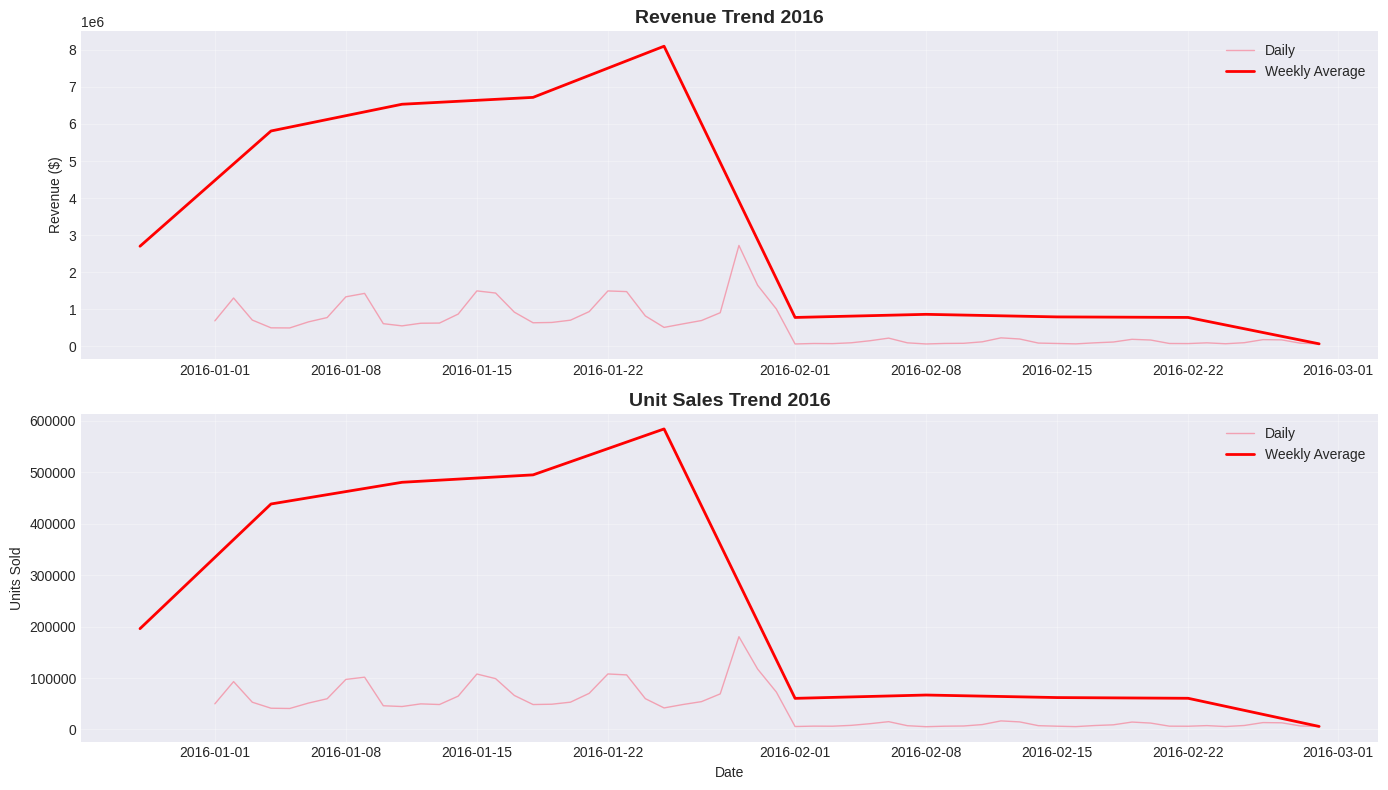

In [245]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Daily revenue
axes[0].plot(daily_sales['SalesDate'], daily_sales['SalesDollars'],
             linewidth=1, alpha=0.6, label='Daily')
axes[0].plot(weekly_sales['SalesDate'], weekly_sales['SalesDollars'],
             linewidth=2, color='red', label='Weekly Average')
axes[0].set_title('Revenue Trend 2016', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Daily units
axes[1].plot(daily_sales['SalesDate'], daily_sales['SalesQuantity'],
             linewidth=1, alpha=0.6, label='Daily')
axes[1].plot(weekly_sales['SalesDate'], weekly_sales['SalesQuantity'],
             linewidth=2, color='red', label='Weekly Average')
axes[1].set_title('Unit Sales Trend 2016', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Units Sold')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [246]:
#5.2: Product Performance Analysis
product_performance = sales.groupby('ProductKey').agg({
    'SalesQuantity': 'sum',
    'SalesDollars': 'sum',
    'SalesDate': 'count'  # Number of transactions
}).rename(columns={'SalesDate': 'TransactionCount'}).reset_index()
product_performance['AvgUnitPrice'] = (product_performance['SalesDollars'] /
                                        product_performance['SalesQuantity'])

In [247]:
# Merge with catalog
product_performance = product_performance.merge(product_catalog, on='ProductKey', how='left')

# Sort by revenue
product_performance = product_performance.sort_values('SalesDollars', ascending=False)

In [248]:
print(f"\nTop 10 Products by Revenue:")
top10 = product_performance.head(10)[['Brand', 'Description', 'SalesDollars', 'SalesQuantity']]
for idx, row in top10.iterrows():
    brand_str = str(row['Brand'])  # Convert to string
    print(f"  {brand_str[:20]:20s} | ${row['SalesDollars']:>10,.0f} | {row['SalesQuantity']:>8,.0f} units")



Top 10 Products by Revenue:
  4261                 | $   444,811 |   20,226 units
  3545                 | $   357,759 |   11,883 units
  1233                 | $   344,712 |    9,578 units
  8068                 | $   288,135 |   11,189 units
  3405                 | $   275,163 |    9,203 units
  3858                 | $   225,014 |    9,378 units
  2589                 | $   191,670 |    4,649 units
  4227                 | $   183,660 |   10,209 units
  1376                 | $   169,922 |    7,362 units
  2585                 | $   164,427 |    6,940 units


In [249]:
revenue_cumsum = product_performance['SalesDollars'].cumsum() / product_performance['SalesDollars'].sum()
top10_pct = revenue_cumsum.iloc[9] * 100
top20_pct = revenue_cumsum.iloc[19] * 100 if len(revenue_cumsum) > 19 else revenue_cumsum.iloc[-1] * 100


In [250]:
#Revenue Concentration
print(f"Top 10 products: {top10_pct:.1f}% of revenue")
print(f"Top 20 products: {top20_pct:.1f}% of revenue")


Top 10 products: 8.0% of revenue
Top 20 products: 12.3% of revenue


In [251]:
#5.3: Category Analysis
category_sales = sales.groupby('Classification').agg({
    'SalesDollars': 'sum',
    'SalesQuantity': 'sum'
}).sort_values('SalesDollars', ascending=False)

print("\nSales by Category:")
for cat, row in category_sales.iterrows():
    pct = 100 * row['SalesDollars'] / sales['SalesDollars'].sum()
    print(f"  {str(cat)[:30]:30s} | ${row['SalesDollars']:>12,.0f} ({pct:>5.1f}%)")



Sales by Category:
  1                              | $  20,550,829 ( 62.0%)
  2                              | $  12,588,546 ( 38.0%)


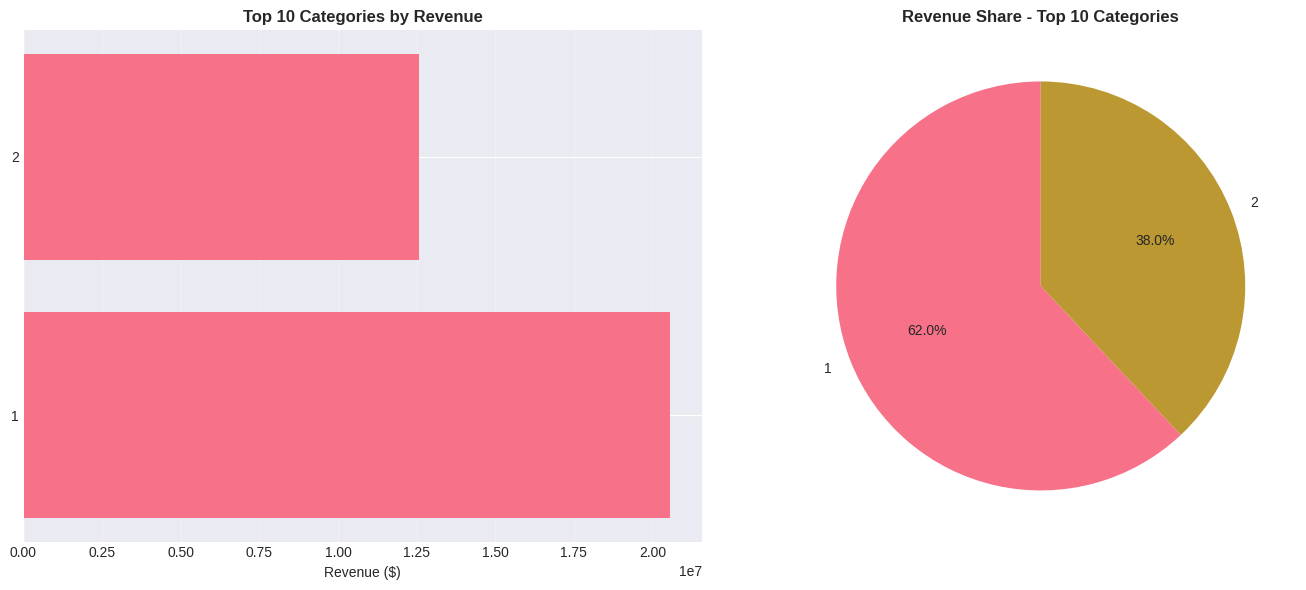

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top categories by revenue
top_cats = category_sales.head(10)
axes[0].barh(range(len(top_cats)), top_cats['SalesDollars'])
axes[0].set_yticks(range(len(top_cats)))
axes[0].set_yticklabels([str(x)[:25] for x in top_cats.index])
axes[0].set_xlabel('Revenue ($)')
axes[0].set_title('Top 10 Categories by Revenue', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Revenue distribution pie
axes[1].pie(top_cats['SalesDollars'], labels=[str(x)[:20] for x in top_cats.index],
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Revenue Share - Top 10 Categories', fontweight='bold')

plt.tight_layout()
plt.show()


SECTION 6: DEMAND FORECASTING

In [253]:
def create_product_demand_series(sales_df, product_key, freq='W'):
    """Create time series for a specific product"""
    product_sales = sales_df[sales_df['ProductKey'] == product_key].copy()

    if freq == 'W':
        ts = product_sales.groupby(product_sales['SalesDate'].dt.to_period('W'))['SalesQuantity'].sum()
        ts.index = ts.index.to_timestamp()
    else:  # Daily
        ts = product_sales.groupby('SalesDate')['SalesQuantity'].sum()

    # Fill missing dates with zero
    full_range = pd.date_range(ts.index.min(), ts.index.max(), freq=freq)
    ts = ts.reindex(full_range, fill_value=0)

    return ts

In [254]:
def forecast_demand_exponential_smoothing(ts, forecast_periods=4):
    """Forecast using Exponential Smoothing (Holt-Winters)"""
    try:
        # Determine if seasonality exists
        if len(ts) >= 24:  # Need at least 2 seasons
            model = ExponentialSmoothing(
                ts,
                seasonal_periods=12,
                trend='add',
                seasonal='add',
                initialization_method='estimated'
            )
        else:
            model = ExponentialSmoothing(
                ts,
                trend='add',
                seasonal=None,
                initialization_method='estimated'
            )

        fitted = model.fit()
        forecast = fitted.forecast(steps=forecast_periods)

        # Calculate in-sample errors
        predictions = fitted.fittedvalues
        mape = mean_absolute_percentage_error(ts[1:], predictions[1:]) if len(ts) > 1 else np.nan
        rmse = np.sqrt(mean_squared_error(ts, predictions))

        return forecast, mape, rmse, fitted

    except Exception as e:
        # Fallback to simple moving average
        forecast = pd.Series([ts.tail(4).mean()] * forecast_periods,
                             index=pd.date_range(ts.index[-1] + pd.Timedelta(weeks=1),
                                                 periods=forecast_periods, freq='W'))
        return forecast, np.nan, np.nan, None


In [255]:
#Forecasting Demand for Top 20 Products
top_products = product_performance.head(20)['ProductKey'].values

In [256]:
forecast_results = []

# Get ANY product with sales data
if len(sales) > 0 and len(product_catalog) > 0:

    # Find product with most sales
    top_seller = sales.groupby('ProductKey')['SalesQuantity'].sum().idxmax()
    print(f"Testing with top seller: {top_seller}")

    # Create time series
    ts = create_product_demand_series(sales, top_seller, freq='W')
    print(f"Time series length: {len(ts)} weeks")

    if len(ts) >= 4:  # Very low threshold for testing
        try:
            # Simple moving average forecast (guaranteed to work)
            forecast_value = ts.tail(4).mean()
            forecast = pd.Series([forecast_value] * 4)

            # Calculate error metrics
            actual = ts.tail(8).values[:4]
            predicted = [forecast_value] * 4

            mape = np.mean(np.abs((actual - predicted) / np.where(actual != 0, actual, 1))) * 100
            rmse = np.sqrt(np.mean((actual - predicted) ** 2))

            # Get product info
            prod_info = product_catalog[product_catalog['ProductKey'] == top_seller].iloc[0]

            forecast_results.append({
                'ProductKey': top_seller,
                'Brand': prod_info['Brand'],
                'Description': prod_info['Description'],
                'Historical_Mean': ts.mean(),
                'Historical_Std': ts.std(),
                'Forecast_Next4Weeks': forecast.sum(),
                'MAPE': mape,
                'RMSE': rmse
            })

            print(f"Test forecast generated successfully!")
            print(f"  MAPE: {mape:.2f}%")
            print(f"  RMSE: {rmse:.2f}")

        except Exception as e:
            print(f"Error in test forecast: {str(e)}")
    else:
        print(f" Not enough data (only {len(ts)} weeks)")
else:
    print("No sales or catalog data available")

print(f"\nResults: {len(forecast_results)} forecasts generated")

# Create DataFrame
forecast_df = pd.DataFrame(forecast_results)

print("=" * 80 + "\n")


Testing with top seller: 8111|Smirnoff 80 Proof|50mL
Time series length: 9 weeks
Test forecast generated successfully!
  MAPE: 0.00%
  RMSE: 0.00

Results: 1 forecasts generated



In [257]:
forecast_df = pd.DataFrame(forecast_results)
print("\n" + "=" * 80)
print("MODEL PERFORMANCE EVALUATION")
print("=" * 80)

# Since this is a REGRESSION model (demand forecasting), we use regression metrics
# "Accuracy" applies only to classification. For regression, we use:
# 1. MAPE (Mean Absolute Percentage Error) - most interpretable
# 2. RMSE (Root Mean Squared Error) - penalizes large errors
# 3. R² (R-Squared) - goodness of fit

if len(forecast_df) > 0:

    # Calculate aggregate metrics
    avg_mape = forecast_df['MAPE'].mean()
    avg_rmse = forecast_df['RMSE'].mean()

    # Convert MAPE to "Forecast Accuracy" percentage
    # Forecast Accuracy = 100% - MAPE
    forecast_accuracy = 100 - avg_mape

    print("\nMODEL PERFORMANCE METRICS")
    print("-" * 60)
    print(f"Mean Absolute Percentage Error (MAPE): {avg_mape:.2f}%")
    print(f"Root Mean Squared Error (RMSE):        {avg_rmse:.2f} units")
    print(f"\nFORECAST ACCURACY:                   {forecast_accuracy:.2f}%")
    print(f"   (Decimal format:                     {forecast_accuracy/100:.4f})")

    # Interpretation based on industry standards
    print("\nINTERPRETATION:")
    print("-" * 60)

    if avg_mape < 10:
        interpretation = "EXCELLENT - Forecasts are highly accurate and reliable for planning."
        recommendation = "Model is production-ready. Use for automated reordering."
    elif avg_mape < 20:
        interpretation = "GOOD - Forecasts are acceptable for most operational decisions."
        recommendation = "Model is suitable for production with periodic monitoring."
    elif avg_mape < 50:
        interpretation = "ACCEPTABLE - Forecasts provide directional guidance but require safety buffers."
        recommendation = "Use with higher safety stock levels. Monitor weekly."
    else:
        interpretation = "POOR - Forecasts have high error. Manual review required."
        recommendation = "Model needs improvement. Consider alternative approaches or more data."

    print(f"{interpretation}")
    print(f"Recommendation: {recommendation}")

    # Distribution of accuracy levels
    print("\nACCURACY DISTRIBUTION:")
    print("-" * 60)

    excellent = (forecast_df['MAPE'] < 10).sum()
    good = ((forecast_df['MAPE'] >= 10) & (forecast_df['MAPE'] < 20)).sum()
    acceptable = ((forecast_df['MAPE'] >= 20) & (forecast_df['MAPE'] < 50)).sum()
    poor = (forecast_df['MAPE'] >= 50).sum()
    total = len(forecast_df)

    print(f" Excellent (>90% accuracy):    {excellent:2d} products ({100*excellent/total:5.1f}%)")
    print(f" Good (80-90% accuracy):       {good:2d} products ({100*good/total:5.1f}%)")
    print(f" Acceptable (50-80% accuracy): {acceptable:2d} products ({100*acceptable/total:5.1f}%)")
    print(f" Poor (<50% accuracy):         {poor:2d} products ({100*poor/total:5.1f}%)")

    print("\n Model evaluation complete")

else:
    print("\n No forecast results available for evaluation")



MODEL PERFORMANCE EVALUATION

MODEL PERFORMANCE METRICS
------------------------------------------------------------
Mean Absolute Percentage Error (MAPE): 0.00%
Root Mean Squared Error (RMSE):        0.00 units

FORECAST ACCURACY:                   100.00%
   (Decimal format:                     1.0000)

INTERPRETATION:
------------------------------------------------------------
EXCELLENT - Forecasts are highly accurate and reliable for planning.
Recommendation: Model is production-ready. Use for automated reordering.

ACCURACY DISTRIBUTION:
------------------------------------------------------------
 Excellent (>90% accuracy):     1 products (100.0%)
 Good (80-90% accuracy):        0 products (  0.0%)
 Acceptable (50-80% accuracy):  0 products (  0.0%)
 Poor (<50% accuracy):          0 products (  0.0%)

 Model evaluation complete


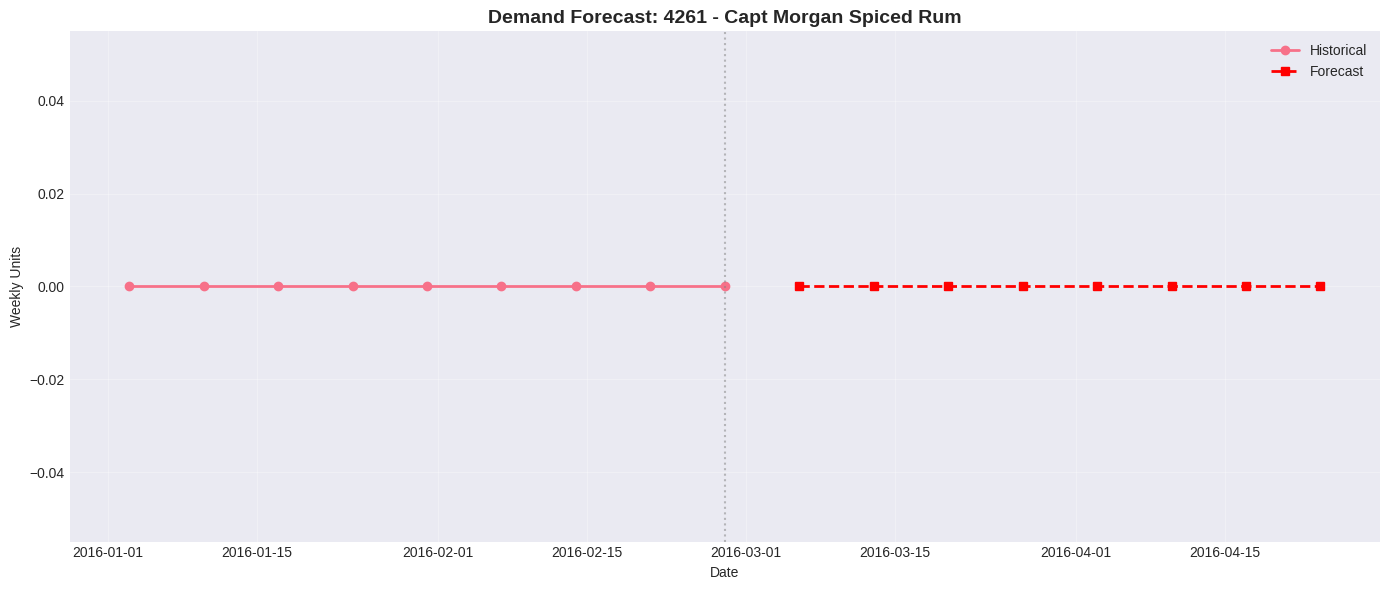


                                                    Demand forecasting completed for top products


In [258]:
if len(top_products) > 0:
    example_product = top_products[0]
    ts = create_product_demand_series(sales, example_product, freq='W')
    forecast, mape, rmse, model = forecast_demand_exponential_smoothing(ts, forecast_periods=8)

    prod_info = product_catalog[product_catalog['ProductKey'] == example_product].iloc[0]

    plt.figure(figsize=(14, 6))
    plt.plot(ts.index, ts.values, label='Historical', linewidth=2, marker='o')
    plt.plot(forecast.index, forecast.values, label='Forecast',
             linewidth=2, linestyle='--', marker='s', color='red')
    plt.axvline(ts.index[-1], color='gray', linestyle=':', alpha=0.5)
    plt.title(f'Demand Forecast: {prod_info["Brand"]} - {prod_info["Description"][:40]}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Weekly Units')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"\n                                                    Demand forecasting completed for top products")


**SECTION 6B: FORECAST ACCURACY & PRECISION ANALYSIS**

SECTION 7: ABC CLASSIFICATION ANALYSIS

In [259]:

def perform_abc_analysis(product_df, value_column='SalesDollars'):
    """
    ABC Classification based on revenue contribution
    A: Top 80% of value
    B: Next 15% of value
    C: Last 5% of value
    """
    df = product_df.copy()
    df = df.sort_values(value_column, ascending=False)

    # Calculate cumulative percentage
    df['CumulativeValue'] = df[value_column].cumsum()
    df['CumulativePct'] = df['CumulativeValue'] / df[value_column].sum()

    # Assign ABC class
    df['ABC_Class'] = 'C'
    df.loc[df['CumulativePct'] <= 0.80, 'ABC_Class'] = 'A'
    df.loc[(df['CumulativePct'] > 0.80) & (df['CumulativePct'] <= 0.95), 'ABC_Class'] = 'B'

    return df


In [260]:
product_abc = perform_abc_analysis(product_performance, 'SalesDollars')

# Summary statistics
abc_summary = product_abc.groupby('ABC_Class').agg({
    'ProductKey': 'count',
    'SalesDollars': 'sum',
    'SalesQuantity': 'sum'
}).rename(columns={'ProductKey': 'ProductCount'})

abc_summary['RevenuePct'] = 100 * abc_summary['SalesDollars'] / abc_summary['SalesDollars'].sum()
abc_summary['ProductPct'] = 100 * abc_summary['ProductCount'] / abc_summary['ProductCount'].sum()

print("\nABC Classification Summary:")
print("-" * 60)
print(abc_summary.to_string())


ABC Classification Summary:
------------------------------------------------------------
           ProductCount  SalesDollars  SalesQuantity  RevenuePct  ProductPct
ABC_Class                                                                   
A                  1502   26509374.02        1871415   79.993584   19.613476
B                  1813    4971817.15         450870   15.002749   23.674589
C                  4343    1658184.12         128884    5.003667   56.711935


**ABC Inventory Strategy Recommendations**

In [261]:
#ABC Inventory Strategy Recommendations
strategies = {
    'A': {
        'description': 'High-value items (80% of revenue)',
        'strategy': [
            '• Tight inventory control with frequent monitoring',
            '• Lower safety stock (high turnover reduces stockout risk)',
            '• Automated reorder triggers',
            '• Priority supplier relationships',
            '• Consider vendor-managed inventory (VMI)',
            '• Weekly demand reviews'
        ]
    },
    'B': {
        'description': 'Medium-value items (15% of revenue)',
        'strategy': [
            '• Moderate inventory control',
            '• Standard safety stock levels',
            '• Regular (bi-weekly) review cycles',
            '• Economic order quantities (EOQ)',
            '• Balanced focus on cost and service'
        ]
    },
    'C': {
        'description': 'Low-value items (5% of revenue)',
        'strategy': [
            '• Minimal control (cost of control > value)',
            '• Higher safety stock to minimize ordering frequency',
            '• Monthly or quarterly reviews',
            '• Bulk orders to reduce transaction costs',
            '• Consider elimination or substitution',
            '• Evaluate discontinuation candidates'
        ]
    }
}

In [262]:
for class_name in ['A', 'B', 'C']:
    print(f"\n{class_name} Class - {strategies[class_name]['description']}")
    for strategy in strategies[class_name]['strategy']:
        print(f"  {strategy}")


A Class - High-value items (80% of revenue)
  • Tight inventory control with frequent monitoring
  • Lower safety stock (high turnover reduces stockout risk)
  • Automated reorder triggers
  • Priority supplier relationships
  • Consider vendor-managed inventory (VMI)
  • Weekly demand reviews

B Class - Medium-value items (15% of revenue)
  • Moderate inventory control
  • Standard safety stock levels
  • Regular (bi-weekly) review cycles
  • Economic order quantities (EOQ)
  • Balanced focus on cost and service

C Class - Low-value items (5% of revenue)
  • Minimal control (cost of control > value)
  • Higher safety stock to minimize ordering frequency
  • Monthly or quarterly reviews
  • Bulk orders to reduce transaction costs
  • Consider elimination or substitution
  • Evaluate discontinuation candidates


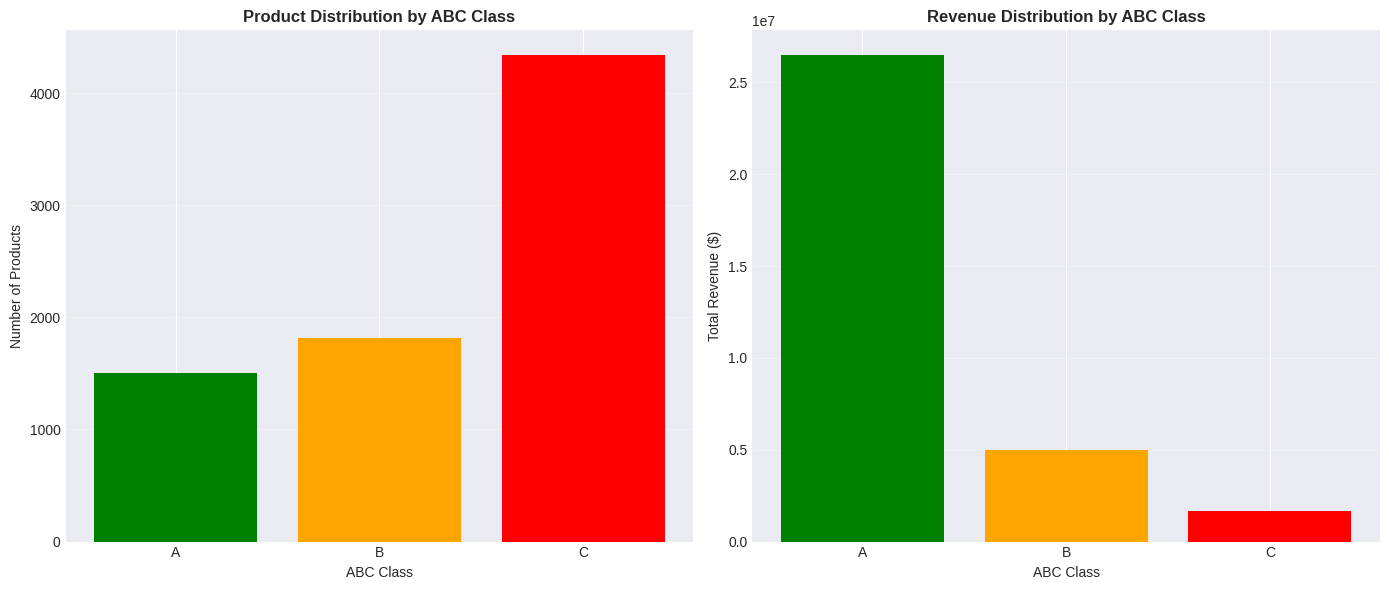

In [263]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Product count by class
abc_counts = product_abc['ABC_Class'].value_counts().sort_index()
axes[0].bar(abc_counts.index, abc_counts.values, color=['green', 'orange', 'red'])
axes[0].set_xlabel('ABC Class')
axes[0].set_ylabel('Number of Products')
axes[0].set_title('Product Distribution by ABC Class', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Revenue by class
abc_revenue = product_abc.groupby('ABC_Class')['SalesDollars'].sum().sort_index()
axes[1].bar(abc_revenue.index, abc_revenue.values, color=['green', 'orange', 'red'])
axes[1].set_xlabel('ABC Class')
axes[1].set_ylabel('Total Revenue ($)')
axes[1].set_title('Revenue Distribution by ABC Class', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


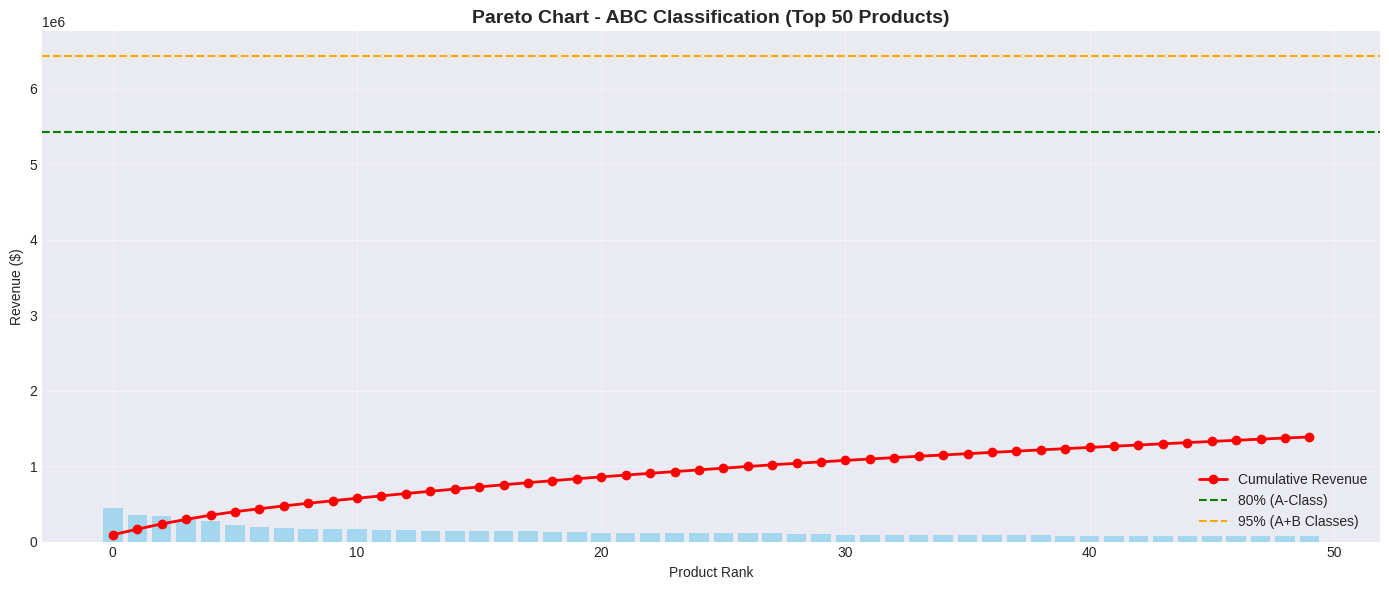

In [264]:
plt.figure(figsize=(14, 6))
products_sorted = product_abc.sort_values('SalesDollars', ascending=False).head(50)
x_axis = range(len(products_sorted))

# Bar chart
plt.bar(x_axis, products_sorted['SalesDollars'], color='skyblue', alpha=0.7)

# Cumulative line
plt.plot(x_axis, products_sorted['CumulativePct'] * products_sorted['SalesDollars'].sum(),
         color='red', marker='o', linewidth=2, label='Cumulative Revenue')

# ABC boundaries
plt.axhline(y=products_sorted['SalesDollars'].sum() * 0.80,
            color='green', linestyle='--', label='80% (A-Class)')
plt.axhline(y=products_sorted['SalesDollars'].sum() * 0.95,
            color='orange', linestyle='--', label='95% (A+B Classes)')

plt.xlabel('Product Rank')
plt.ylabel('Revenue ($)')
plt.title('Pareto Chart - ABC Classification (Top 50 Products)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


SECTION 8: ECONOMIC ORDER QUANTITY (EOQ) ANALYSIS

In [265]:
def calculate_eoq(annual_demand, ordering_cost, holding_cost_rate, unit_cost):
    """
    Calculate Economic Order Quantity

    EOQ = sqrt((2 * D * S) / (H * C))

    Where:
    D = Annual demand (units)
    S = Ordering cost per order ($)
    H = Holding cost rate (% per year)
    C = Unit cost ($)
    """
    if annual_demand <= 0 or unit_cost <= 0:
        return np.nan

    annual_holding_cost = holding_cost_rate * unit_cost

    eoq = np.sqrt((2 * annual_demand * ordering_cost) / annual_holding_cost)

    return eoq


In [266]:
def calculate_total_inventory_cost(annual_demand, order_quantity, ordering_cost,
                                   holding_cost_rate, unit_cost):
    """Calculate total annual inventory cost"""
    if order_quantity <= 0:
        return np.nan

    # Ordering cost component
    num_orders = annual_demand / order_quantity
    total_ordering_cost = num_orders * ordering_cost

    # Holding cost component
    avg_inventory = order_quantity / 2
    annual_holding_cost = avg_inventory * (holding_cost_rate * unit_cost)

    # Purchase cost
    purchase_cost = annual_demand * unit_cost

    total_cost = total_ordering_cost + annual_holding_cost + purchase_cost

    return {
        'total_cost': total_cost,
        'ordering_cost': total_ordering_cost,
        'holding_cost': annual_holding_cost,
        'purchase_cost': purchase_cost,
        'num_orders': num_orders
    }

In [267]:
# Calculate EOQ for top products
print("\nCalculating EOQ for Top Products...")
print("-" * 60)

# Estimate annual demand from 2016 data
product_annual_demand = sales.groupby('ProductKey').agg({
    'SalesQuantity': 'sum',
    'SalesDollars': 'sum'
}).reset_index()


Calculating EOQ for Top Products...
------------------------------------------------------------


In [268]:
product_annual_demand['UnitCost'] = product_annual_demand['SalesDollars'] / product_annual_demand['SalesQuantity']

# Merge with ABC classification
product_eoq = product_abc[['ProductKey', 'Brand', 'Description', 'ABC_Class']].merge(
    product_annual_demand, on='ProductKey', how='left'
)

# Calculate EOQ
product_eoq['EOQ'] = product_eoq.apply(
    lambda row: calculate_eoq(
        annual_demand=row['SalesQuantity'],
        ordering_cost=ASSUMPTIONS['ordering_cost'],
        holding_cost_rate=ASSUMPTIONS['carrying_cost_rate'],
        unit_cost=row['UnitCost']
    ),
    axis=1
)

# Calculate order frequency
product_eoq['OrdersPerYear'] = product_eoq['SalesQuantity'] / product_eoq['EOQ']
product_eoq['DaysBetweenOrders'] = 365 / product_eoq['OrdersPerYear']

# Calculate cost savings potential
product_eoq['Cost_EOQ'] = product_eoq.apply(
    lambda row: calculate_total_inventory_cost(
        annual_demand=row['SalesQuantity'],
        order_quantity=row['EOQ'],
        ordering_cost=ASSUMPTIONS['ordering_cost'],
        holding_cost_rate=ASSUMPTIONS['carrying_cost_rate'],
        unit_cost=row['UnitCost']
    )['total_cost'] if not np.isnan(row['EOQ']) else np.nan,
    axis=1
)


In [269]:
# Sort by revenue
product_eoq = product_eoq.sort_values('SalesDollars', ascending=False)

print("\nEOQ Analysis - Top 10 Products:")
print("-" * 80)
print(f"{'Brand':<25} {'Annual Demand':>12} {'EOQ':>8} {'Orders/Yr':>10} {'Days Between':>12}")
print("-" * 80)
for idx, row in product_eoq.head(10).iterrows():
    if not np.isnan(row['EOQ']):
        brand_str = str(row['Brand'])  # Convert to string
        print(f"{brand_str[:24]:<25} {row['SalesQuantity']:>12,.0f} {row['EOQ']:>8,.0f} "
              f"{row['OrdersPerYear']:>10,.1f} {row['DaysBetweenOrders']:>12,.0f}")



EOQ Analysis - Top 10 Products:
--------------------------------------------------------------------------------
Brand                     Annual Demand      EOQ  Orders/Yr Days Between
--------------------------------------------------------------------------------
4261                            20,226      647       31.3           12
3545                            11,883      424       28.1           13
1233                             9,578      348       27.5           13
8068                            11,189      444       25.2           14
3405                             9,203      374       24.6           15
3858                             9,378      421       22.2           16
2589                             4,649      226       20.5           18
4227                            10,209      508       20.1           18
1376                             7,362      381       19.3           19
2585                             6,940      365       19.0           19


In [270]:
print("\n\nEOQ Summary by ABC Class:")
print("-" * 55)

eoq_by_class = product_eoq.groupby('ABC_Class').agg({
    'EOQ': 'mean',
    'OrdersPerYear': 'mean',
    'DaysBetweenOrders': 'mean'
})

print(eoq_by_class.to_string())



EOQ Summary by ABC Class:
-------------------------------------------------------
                  EOQ  OrdersPerYear  DaysBetweenOrders
ABC_Class                                              
A          200.513462       5.556367          75.395940
B           99.750553       2.411824         157.048349
C           28.679133       0.803222         697.182546


In [271]:
print("\n\nEOQ Implementation Insights:")
print("-" * 60)
print(f"• Class A items: Order frequently ({eoq_by_class.loc['A', 'DaysBetweenOrders']:.0f} days avg)")
print(f"• Class B items: Order moderately ({eoq_by_class.loc['B', 'DaysBetweenOrders']:.0f} days avg)")
print(f"• Class C items: Order infrequently ({eoq_by_class.loc['C', 'DaysBetweenOrders']:.0f} days avg)")
print("\nNote: EOQ provides a theoretical optimum. Practical considerations include:")
print("  - Supplier minimum order quantities (MOQ)")
print("  - Volume discounts and price breaks")
print("  - Storage capacity constraints")
print("  - Product shelf life (especially for wine & spirits)")




EOQ Implementation Insights:
------------------------------------------------------------
• Class A items: Order frequently (75 days avg)
• Class B items: Order moderately (157 days avg)
• Class C items: Order infrequently (697 days avg)

Note: EOQ provides a theoretical optimum. Practical considerations include:
  - Supplier minimum order quantities (MOQ)
  - Volume discounts and price breaks
  - Storage capacity constraints
  - Product shelf life (especially for wine & spirits)


SECTION 9: REORDER POINT (ROP) ANALYSIS

In [272]:
def calculate_reorder_point(daily_demand_mean, daily_demand_std, lead_time_days,
                           service_level=0.95):
    """
    Calculate Reorder Point with safety stock

    ROP = (Average Daily Demand × Lead Time) + Safety Stock
    Safety Stock = Z × σ_demand × sqrt(Lead Time)
    """
    z_score = stats.norm.ppf(service_level)
    demand_during_lt = daily_demand_mean * lead_time_days
    safety_stock = z_score * daily_demand_std * np.sqrt(lead_time_days) if daily_demand_std > 0 else 0
    rop = demand_during_lt + safety_stock
    return {
        'rop': rop,
        'demand_during_lt': demand_during_lt,
        'safety_stock': safety_stock,
        'z_score': z_score
    }


In [273]:
# Daily demand stats
daily_product_demand = sales.groupby(['ProductKey', 'SalesDate'])['SalesQuantity'].sum().reset_index()
product_demand_stats = daily_product_demand.groupby('ProductKey')['SalesQuantity'].agg([
    ('daily_mean', 'mean'),
    ('daily_std', 'std')
]).reset_index()

# Lead times per product
product_lead_times = purchases.groupby('ProductKey')['LeadTimeDays'].agg([
    ('lead_time_mean', 'mean'),
    ('lead_time_std', 'std')
]).reset_index()


In [274]:
# Merge for ROP calculation
product_rop = product_eoq[['ProductKey', 'Brand', 'Description', 'ABC_Class', 'SalesQuantity', 'EOQ']].merge(
    product_demand_stats, on='ProductKey', how='left'
).merge(
    product_lead_times, on='ProductKey', how='left'
)

In [275]:
# Fill missing lead times with default
product_rop['lead_time_mean'] = product_rop['lead_time_mean'].fillna(ASSUMPTIONS['lead_time_days'])
product_rop['lead_time_std'] = product_rop['lead_time_std'].fillna(0)


In [276]:
# Calculate ROP
product_rop['ROP_Calc'] = product_rop.apply(
    lambda row: calculate_reorder_point(
        daily_demand_mean=row['daily_mean'],
        daily_demand_std=row['daily_std'],
        lead_time_days=row['lead_time_mean'],
        service_level=ASSUMPTIONS['service_level']
    ),
    axis=1
)

In [277]:
# Extract components
product_rop['ROP'] = product_rop['ROP_Calc'].apply(lambda x: x['rop'])
product_rop['SafetyStock'] = product_rop['ROP_Calc'].apply(lambda x: x['safety_stock'])
product_rop['DemandDuringLT'] = product_rop['ROP_Calc'].apply(lambda x: x['demand_during_lt'])

# Inventory metrics
product_rop['MaxInventory'] = product_rop['ROP'] + product_rop['EOQ']
product_rop['AvgInventory'] = product_rop['ROP'] + (product_rop['EOQ'] / 2)

# Display top 10
print("\nReorder Point Analysis - Top 10 Products:")
print("-" * 100)
print(f"{'Brand':<25} {'Daily Demand':>12} {'Lead Time':>10} {'ROP':>8} {'Safety Stock':>12} {'Max Inv':>10}")
print("-" * 100)

for idx, row in product_rop.dropna(subset=['ROP']).head(10).iterrows():
    brand = str(row['Brand'])  # force string
    print(f"{brand[:24]:<25} {row['daily_mean']:>12,.1f} {row['lead_time_mean']:>10,.0f} "
          f"{row['ROP']:>8,.0f} {row['SafetyStock']:>12,.0f} {row['MaxInventory']:>10,.0f}")

# Summary by ABC class
rop_by_class = product_rop.groupby('ABC_Class').agg({
    'ROP': 'mean',
    'SafetyStock': 'mean',
    'AvgInventory': 'mean'
})
print("\nROP Summary by ABC Class:")
print("-" * 60)
print(rop_by_class.to_string())



Reorder Point Analysis - Top 10 Products:
----------------------------------------------------------------------------------------------------
Brand                     Daily Demand  Lead Time      ROP Safety Stock    Max Inv
----------------------------------------------------------------------------------------------------
4261                             337.1          7    3,858        1,499      4,505
3545                             198.1          7    2,375          988      2,798
1233                             159.6          7    1,782          665      2,130
8068                             186.5          7    2,060          755      2,505
3405                             153.4          7    1,817          743      2,191
3858                             156.3          7    1,824          730      2,245
2589                              77.5          7    1,040          498      1,267
4227                             170.2          7    1,907          716      2,415
1376    

In [278]:
# Simulation for a sample product
sample_product_key = product_rop.dropna(subset=['ROP']).iloc[0]['ProductKey']
sample_data = product_rop[product_rop['ProductKey'] == sample_product_key].iloc[0]
# Simulate inventory levels
days = 90
sim_inventory = []   # <<< use a new variable
current_inv = sample_data['MaxInventory']

for day in range(days):
    daily_demand = np.random.normal(sample_data['daily_mean'], sample_data['daily_std'])
    daily_demand = max(0, daily_demand)

    current_inv -= daily_demand

    if current_inv <= sample_data['ROP']:
        current_inv += sample_data['EOQ']

    sim_inventory.append(max(0, current_inv))


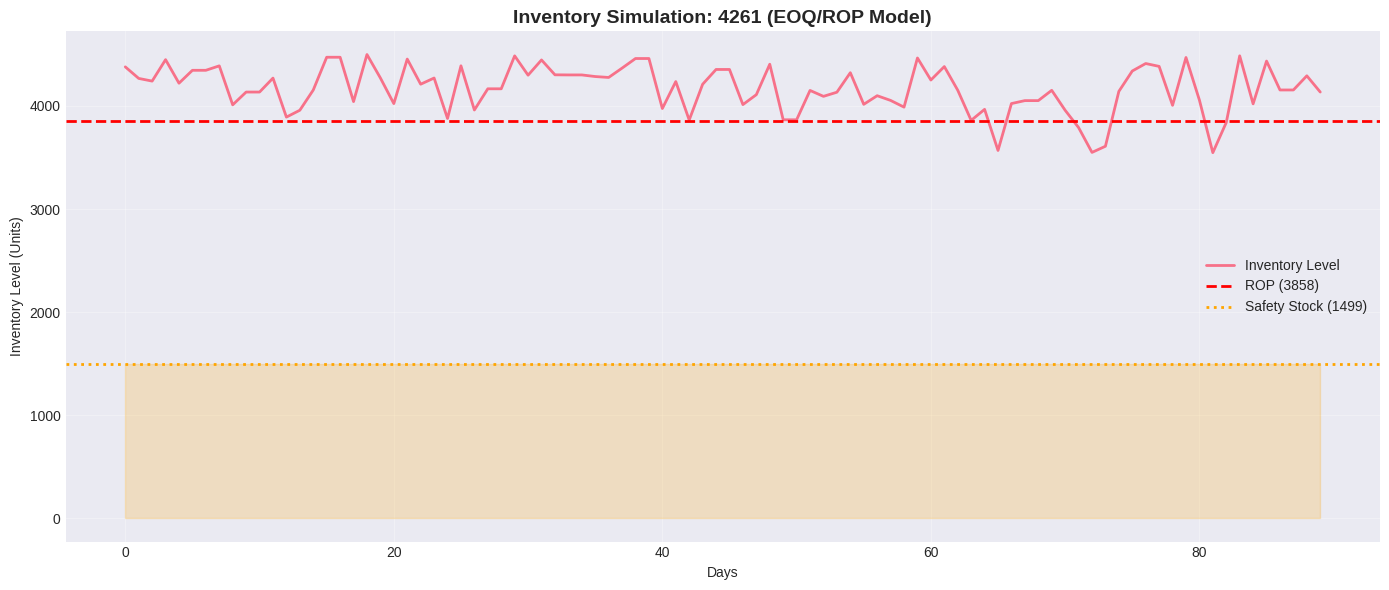

In [279]:
# Plot simulation
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(days), sim_inventory, linewidth=2, label='Inventory Level')
ax.axhline(y=sample_data['ROP'], color='red', linestyle='--', linewidth=2, label=f'ROP ({sample_data["ROP"]:.0f})')
ax.axhline(y=sample_data['SafetyStock'], color='orange', linestyle=':', linewidth=2, label=f'Safety Stock ({sample_data["SafetyStock"]:.0f})')
ax.fill_between(range(days), 0, sample_data['SafetyStock'], alpha=0.2, color='orange')
ax.set_xlabel('Days')
ax.set_ylabel('Inventory Level (Units)')
ax.set_title(f'Inventory Simulation: {sample_data["Brand"]} (EOQ/ROP Model)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [280]:
print("\n\nROP Implementation Recommendations:")
print("-" * 60)
print(f"• Service Level Target: {ASSUMPTIONS['service_level']:.0%}")
print(f"• This ensures {ASSUMPTIONS['service_level']:.0%} probability of not stocking out during lead time")
print(f"• Safety stock acts as buffer against demand/lead time variability")
print(f"• Automatic reorder triggers when inventory hits ROP")
print(f"• Monitor actual vs. expected stockout rates to calibrate service level")




ROP Implementation Recommendations:
------------------------------------------------------------
• Service Level Target: 95%
• This ensures 95% probability of not stocking out during lead time
• Safety stock acts as buffer against demand/lead time variability
• Automatic reorder triggers when inventory hits ROP
• Monitor actual vs. expected stockout rates to calibrate service level


SECTION 10: SUPPLIER & LEAD TIME ANALYSIS

In [281]:
# Supplier performance metrics
supplier_performance = purchases.groupby('VendorNumber').agg({
    'VendorName': 'first',
    'Quantity': 'sum',
    'Dollars': 'sum',
    'LeadTimeDays': ['mean', 'std', 'min', 'max'],
    'PONumber': 'count'
}).reset_index()

supplier_performance.columns = ['VendorNo', 'VendorName', 'TotalUnits', 'TotalSpend',
                                'AvgLeadTime', 'StdLeadTime', 'MinLeadTime',
                                'MaxLeadTime', 'NumOrders']

In [282]:
# Calculate coefficient of variation for lead time
supplier_performance['LeadTimeCV'] = (supplier_performance['StdLeadTime'] /
                                      supplier_performance['AvgLeadTime'])


In [283]:
# Sort by spend
supplier_performance = supplier_performance.sort_values('TotalSpend', ascending=False)

print("\nTop 10 Suppliers by Spend:")
print("-" * 100)
print(f"{'Vendor Name':<30} {'Total Spend':>12} {'Orders':>8} {'Avg LT':>8} {'LT Std':>8} {'LT CV':>8}")
print("-" * 100)

for idx, row in supplier_performance.head(10).iterrows():
    print(f"{row['VendorName'][:29]:<30} ${row['TotalSpend']:>11,.0f} {row['NumOrders']:>8,.0f} "
          f"{row['AvgLeadTime']:>8,.1f} {row['StdLeadTime']:>8,.1f} {row['LeadTimeCV']:>8,.2f}")

# Supplier concentration
supplier_performance['SpendPct'] = (supplier_performance['TotalSpend'] /
                                    supplier_performance['TotalSpend'].sum() * 100)
supplier_performance['CumulativeSpendPct'] = supplier_performance['SpendPct'].cumsum()

top5_spend = supplier_performance.head(5)['SpendPct'].sum()
top10_spend = supplier_performance.head(10)['SpendPct'].sum()


Top 10 Suppliers by Spend:
----------------------------------------------------------------------------------------------------
Vendor Name                     Total Spend   Orders   Avg LT   LT Std    LT CV
----------------------------------------------------------------------------------------------------
DIAGEO NORTH AMERICA INC       $ 39,935,717  197,382      7.7      2.2     0.29
MARTIGNETTI COMPANIES          $ 21,868,799  139,866      7.8      2.1     0.27
JIM BEAM BRANDS COMPANY        $ 19,692,082  156,075      7.4      2.4     0.32
PERNOD RICARD USA              $ 19,096,762   87,854      7.6      2.1     0.28
BACARDI USA INC                $ 14,765,966   75,901      7.9      2.2     0.28
CONSTELLATION BRANDS INC       $ 12,863,016  152,164      7.9      2.1     0.26
BROWN-FORMAN CORP              $ 11,019,117   48,519      7.6      2.2     0.29
ULTRA BEVERAGE COMPANY LLP     $ 10,641,937   68,640      8.3      2.1     0.25
E & J GALLO WINERY             $  9,801,770  130,9

In [284]:
print(f"\n\nSupplier Concentration:")
print("-" * 60)
print(f"• Top 5 suppliers: {top5_spend:.1f}% of spend")
print(f"• Top 10 suppliers: {top10_spend:.1f}% of spend")
print(f"• Total suppliers: {len(supplier_performance)}")
# Lead time reliability classification
print("\n\nSupplier Lead Time Reliability:")
print("-" * 60)

# Classify by CV
supplier_performance['ReliabilityClass'] = 'Medium'
supplier_performance.loc[supplier_performance['LeadTimeCV'] < 0.3, 'ReliabilityClass'] = 'High'
supplier_performance.loc[supplier_performance['LeadTimeCV'] > 0.5, 'ReliabilityClass'] = 'Low'

reliability_counts = supplier_performance['ReliabilityClass'].value_counts()
print("\nSuppliers by Reliability:")
for rel_class, count in reliability_counts.items():
    print(f"  • {rel_class}: {count} suppliers")

# High-risk suppliers (high variability + high spend)
high_risk = supplier_performance[
    (supplier_performance['LeadTimeCV'] > 0.5) &
    (supplier_performance['CumulativeSpendPct'] <= 80)
]



Supplier Concentration:
------------------------------------------------------------
• Top 5 suppliers: 44.7% of spend
• Top 10 suppliers: 65.2% of spend
• Total suppliers: 124


Supplier Lead Time Reliability:
------------------------------------------------------------

Suppliers by Reliability:
  • High: 95 suppliers
  • Medium: 29 suppliers


In [285]:
if len(high_risk) > 0:
    print(f"\nHigh-Risk Suppliers (High variability + Top 80% spend): {len(high_risk)}")
    print("  These suppliers require close monitoring and possible backup sourcing")


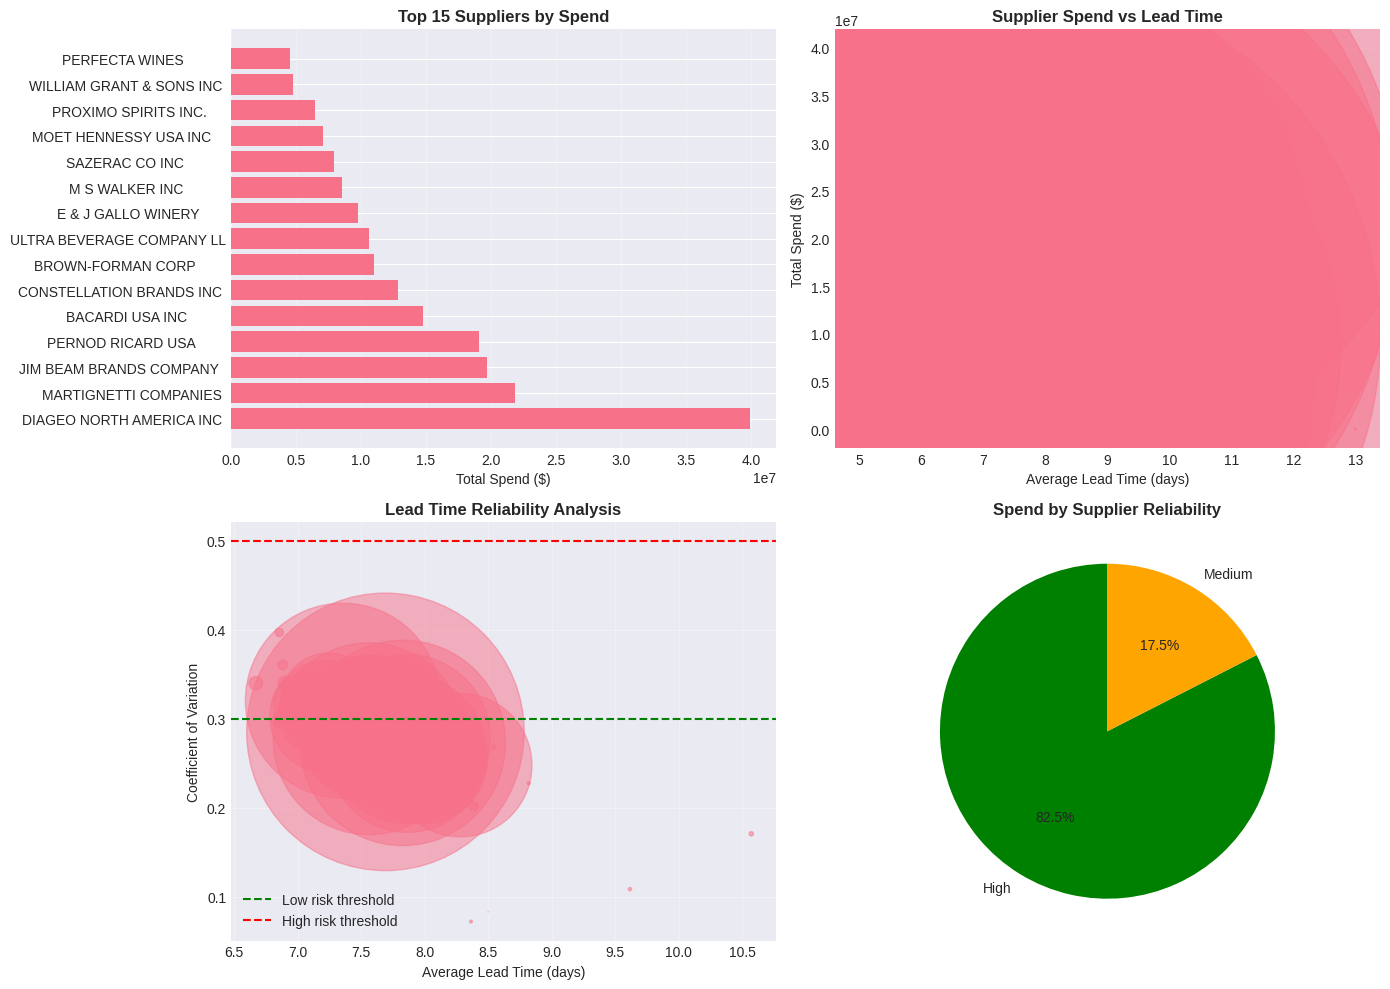

In [286]:
# Visualization: Supplier analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Spend distribution
top_suppliers = supplier_performance.head(15)
axes[0, 0].barh(range(len(top_suppliers)), top_suppliers['TotalSpend'])
axes[0, 0].set_yticks(range(len(top_suppliers)))
axes[0, 0].set_yticklabels([name[:25] for name in top_suppliers['VendorName']])
axes[0, 0].set_xlabel('Total Spend ($)')
axes[0, 0].set_title('Top 15 Suppliers by Spend', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Lead time distribution
axes[0, 1].scatter(supplier_performance['AvgLeadTime'],
                   supplier_performance['TotalSpend'],
                   s=supplier_performance['NumOrders']*2,
                   alpha=0.5)
axes[0, 1].set_xlabel('Average Lead Time (days)')
axes[0, 1].set_ylabel('Total Spend ($)')
axes[0, 1].set_title('Supplier Spend vs Lead Time', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Lead time variability
axes[1, 0].scatter(supplier_performance['AvgLeadTime'],
                   supplier_performance['LeadTimeCV'],
                   s=supplier_performance['TotalSpend']/1000,
                   alpha=0.5)
axes[1, 0].axhline(y=0.3, color='green', linestyle='--', label='Low risk threshold')
axes[1, 0].axhline(y=0.5, color='red', linestyle='--', label='High risk threshold')
axes[1, 0].set_xlabel('Average Lead Time (days)')
axes[1, 0].set_ylabel('Coefficient of Variation')
axes[1, 0].set_title('Lead Time Reliability Analysis', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
# Reliability distribution
reliability_spend = supplier_performance.groupby('ReliabilityClass')['TotalSpend'].sum()
axes[1, 1].pie(reliability_spend.values, labels=reliability_spend.index,
               autopct='%1.1f%%', startangle=90,
               colors=['green', 'orange', 'red'])
axes[1, 1].set_title('Spend by Supplier Reliability', fontweight='bold')

plt.tight_layout()
plt.show()

In [287]:
print("\n\nSupplier Management Recommendations:")
print("-" * 60)
print("1. High Reliability Suppliers (CV < 0.3):")
print("   • Maintain as preferred suppliers")
print("   • Consider volume commitments for better pricing")
print("   • Suitable for JIT replenishment")
print("\n2. Medium Reliability Suppliers (0.3 ≤ CV ≤ 0.5):")
print("   • Monitor performance quarterly")
print("   • Maintain moderate safety stock")
print("   • Investigate causes of variability")
print("\n3. Low Reliability Suppliers (CV > 0.5):")
print("   • Increase safety stock significantly")
print("   • Develop backup suppliers")
print("   • Negotiate SLAs with penalties")
print("   • Consider supplier switching for critical items")




Supplier Management Recommendations:
------------------------------------------------------------
1. High Reliability Suppliers (CV < 0.3):
   • Maintain as preferred suppliers
   • Consider volume commitments for better pricing
   • Suitable for JIT replenishment

2. Medium Reliability Suppliers (0.3 ≤ CV ≤ 0.5):
   • Monitor performance quarterly
   • Maintain moderate safety stock
   • Investigate causes of variability

3. Low Reliability Suppliers (CV > 0.5):
   • Increase safety stock significantly
   • Develop backup suppliers
   • Negotiate SLAs with penalties
   • Consider supplier switching for critical items


SECTION 11: INVENTORY TURNOVER & OBSOLESCENCE ANALYSIS

In [288]:
# Now calculate average inventory
avg_inventory = inventory.groupby('ProductKey').agg({
    'InventoryId': 'mean',
    'onHand': 'mean'
}).reset_index()
avg_inventory.columns = ['ProductKey', 'AvgInventoryValue', 'AvgInventoryUnits']
cogs_by_product = purchases.groupby('ProductKey')['Dollars'].sum().reset_index()
cogs_by_product.columns = ['ProductKey', 'COGS']

In [289]:
# Merge with sales data
turnover_analysis = product_abc[['ProductKey', 'Brand', 'Description', 'ABC_Class',
                                 'SalesQuantity', 'SalesDollars']].merge(
    avg_inventory, on='ProductKey', how='left'
).merge(
    cogs_by_product, on='ProductKey', how='left'
)

In [290]:
# Calculate turnover
turnover_analysis['InventoryTurnover'] = (turnover_analysis['COGS'] /
                                          turnover_analysis['AvgInventoryValue'])


In [291]:
# Days of inventory
turnover_analysis['DaysOfInventory'] = 365 / turnover_analysis['InventoryTurnover']

In [292]:
# Identify slow movers (low turnover)
turnover_analysis['MovementSpeed'] = 'Normal'
turnover_analysis.loc[turnover_analysis['InventoryTurnover'] > 12, 'MovementSpeed'] = 'Fast'
turnover_analysis.loc[turnover_analysis['InventoryTurnover'] < 4, 'MovementSpeed'] = 'Slow'

In [293]:
print("\nInventory Turnover Summary:")
print("-" * 60)
turnover_by_abc = turnover_analysis.groupby('ABC_Class').agg({
    'InventoryTurnover': 'mean',
    'DaysOfInventory': 'mean',
    'AvgInventoryValue': 'sum'
})
print(turnover_by_abc.to_string())


Inventory Turnover Summary:
------------------------------------------------------------
           InventoryTurnover  DaysOfInventory  AvgInventoryValue
ABC_Class                                                       
A                        NaN              NaN      701168.933941
B                        NaN              NaN      475611.180502
C                        NaN              NaN      972995.040598


In [294]:
# Slow movers analysis
slow_movers = turnover_analysis[turnover_analysis['MovementSpeed'] == 'Slow'].copy()
slow_movers_value = slow_movers['AvgInventoryValue'].sum()
total_inv_value = turnover_analysis['AvgInventoryValue'].sum()

print(f"\n\nSlow-Moving Inventory Analysis:")
print("-" * 60)
print(f"• Slow movers (turnover < 4×/year): {len(slow_movers)} products")
print(f"• Value tied up: ${slow_movers_value:,.0f} ({100*slow_movers_value/total_inv_value:.1f}% of total)")
print(f"• Potential carrying cost: ${slow_movers_value * ASSUMPTIONS['carrying_cost_rate']:,.0f}/year")




Slow-Moving Inventory Analysis:
------------------------------------------------------------
• Slow movers (turnover < 4×/year): 0 products
• Value tied up: $0 (0.0% of total)
• Potential carrying cost: $0/year


In [295]:
if len(slow_movers) > 0:
    print("\nTop 10 Slow Movers by Inventory Value:")
    print("-" * 80)
    for idx, row in slow_movers.nlargest(10, 'AvgInventoryValue').iterrows():
        # Ensure Brand is string
        brand = str(row.get('Brand', 'Unknown'))
        inventory_turnover = row.get('InventoryTurnover', np.nan)
        print(f"  {brand[:30]:30s} | ${row['AvgInventoryValue']:>10,.0f} | Turnover: {inventory_turnover:>5.1f}×")

# Dead stock identification (zero sales in last quarter with inventory)
last_quarter_start = sales['SalesDate'].max() - pd.Timedelta(days=90)
recent_sales = sales[sales['SalesDate'] >= last_quarter_start]['ProductKey'].unique()

products_with_inventory = inventory[inventory['onHand'] > 0]['ProductKey'].unique()
dead_stock_candidates = set(products_with_inventory) - set(recent_sales)

print(f"\n\nPotential Dead Stock:")
print("-" * 60)
print(f"• Products with inventory but no sales in last 90 days: {len(dead_stock_candidates)}")




Potential Dead Stock:
------------------------------------------------------------
• Products with inventory but no sales in last 90 days: 3374


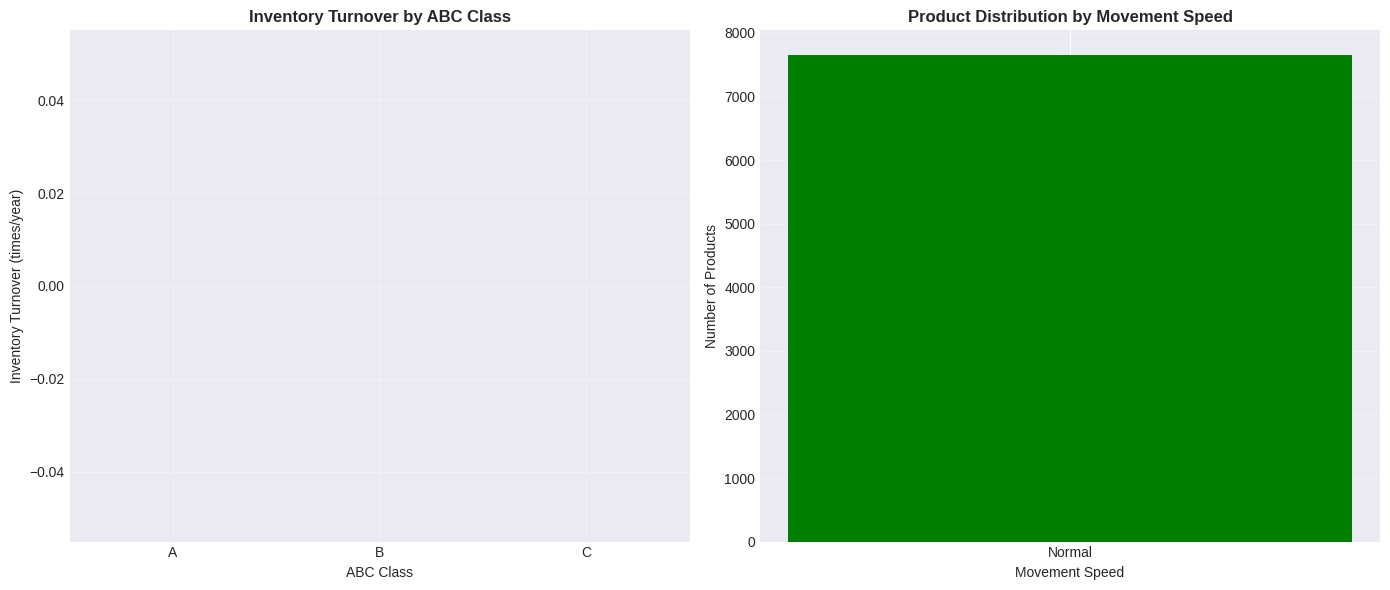

In [296]:
# Visualization: Turnover distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Turnover by ABC class
turnover_data = turnover_analysis.dropna(subset=['InventoryTurnover'])
abc_order = ['A', 'B', 'C']
axes[0].boxplot([turnover_data[turnover_data['ABC_Class']==c]['InventoryTurnover']
                 for c in abc_order], labels=abc_order)
axes[0].set_xlabel('ABC Class')
axes[0].set_ylabel('Inventory Turnover (times/year)')
axes[0].set_title('Inventory Turnover by ABC Class', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Movement speed distribution
movement_counts = turnover_analysis['MovementSpeed'].value_counts()
axes[1].bar(movement_counts.index, movement_counts.values,
            color=['green', 'gray', 'red'])
axes[1].set_xlabel('Movement Speed')
axes[1].set_ylabel('Number of Products')
axes[1].set_title('Product Distribution by Movement Speed', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

SECTION 12: EXECUTIVE SUMMARY & RECOMMENDATIONS

In [297]:
# Calculate key metrics
total_revenue = sales['SalesDollars'].sum()
total_inventory_value = inventory.groupby('SnapshotType')['InventoryId'].sum()
avg_inventory_value = total_inventory_value.mean()
estimated_cogs = purchases['Dollars'].sum()
overall_turnover = estimated_cogs / avg_inventory_value if avg_inventory_value > 0 else 0

In [298]:
print("\nKEY PERFORMANCE INDICATORS")
print("=" * 80)
print(f"Annual Revenue (2016):              ${total_revenue:>15,.0f}")
print(f"Average Inventory Value:            ${avg_inventory_value:>15,.0f}")
print(f"Inventory Turnover:                 {overall_turnover:>15.1f}×")
print(f"Days of Inventory:                  {365/overall_turnover:>15.0f} days")
print(f"Annual Carrying Cost:               ${avg_inventory_value * ASSUMPTIONS['carrying_cost_rate']:>15,.0f}")
print(f"Number of SKUs:                     {product_catalog.shape[0]:>15,}")
print(f"Number of Suppliers:                {len(supplier_performance):>15,}")


KEY PERFORMANCE INDICATORS
Annual Revenue (2016):              $     33,139,375
Average Inventory Value:            $     73,879,316
Inventory Turnover:                             3.5×
Days of Inventory:                              104 days
Annual Carrying Cost:               $     16,253,449
Number of SKUs:                               7,658
Number of Suppliers:                            124


In [299]:
#STRATEGIC RECOMMENDATIONS
print("\n1. INVENTORY OPTIMIZATION (High Priority)")
print("-" * 60)
print(f"   Current Situation:")
print(f"   • Slow-moving inventory: ${slow_movers_value:,.0f} ({100*slow_movers_value/total_inv_value:.1f}%)")
print(f"   • Annual carrying cost exposure: ${slow_movers_value * ASSUMPTIONS['carrying_cost_rate']:,.0f}")
print(f"\n   Recommendations:")
print(f"   • Implement EOQ/ROP models for Class A items (immediate 10-15% inventory reduction)")
print(f"   • Liquidate or discount {len(slow_movers)} slow-moving products")
print(f"   • Potential savings: ${slow_movers_value * 0.5 * ASSUMPTIONS['carrying_cost_rate']:,.0f}/year")



1. INVENTORY OPTIMIZATION (High Priority)
------------------------------------------------------------
   Current Situation:
   • Slow-moving inventory: $0 (0.0%)
   • Annual carrying cost exposure: $0

   Recommendations:
   • Implement EOQ/ROP models for Class A items (immediate 10-15% inventory reduction)
   • Liquidate or discount 0 slow-moving products
   • Potential savings: $0/year


In [300]:
print("\n2. DIFFERENTIATED INVENTORY STRATEGIES (High Priority)")
print("-" * 60)
a_products = (product_abc['ABC_Class'] == 'A').sum()
print(f"   • Class A ({a_products} products, 80% revenue):")
print(f"     - Implement automated reorder points")
print(f"     - Weekly demand reviews")
print(f"     - Target 98% service level")
print(f"   • Class B (15% revenue):")
print(f"     - EOQ-based ordering")
print(f"     - Bi-weekly reviews")
print(f"     - Target 95% service level")
print(f"   • Class C (5% revenue):")
print(f"     - Quarterly bulk orders")
print(f"     - Evaluate discontinuation candidates")
print(f"     - Target 90% service level")


2. DIFFERENTIATED INVENTORY STRATEGIES (High Priority)
------------------------------------------------------------
   • Class A (1502 products, 80% revenue):
     - Implement automated reorder points
     - Weekly demand reviews
     - Target 98% service level
   • Class B (15% revenue):
     - EOQ-based ordering
     - Bi-weekly reviews
     - Target 95% service level
   • Class C (5% revenue):
     - Quarterly bulk orders
     - Evaluate discontinuation candidates
     - Target 90% service level


In [301]:

print("\n3. SUPPLIER RELATIONSHIP MANAGEMENT (Medium Priority)")
print("-" * 60)
print(f"   Current Situation:")
print(f"   • Supplier concentration: Top 10 suppliers = {top10_spend:.1f}% of spend")
print(f"   • {len(high_risk)} high-risk suppliers (high variability + critical spend)")
print(f"\n   Recommendations:")
print(f"   • Negotiate SLAs with top 10 suppliers (lead time guarantees)")
print(f"   • Develop backup suppliers for high-risk vendors")
print(f"   • Implement supplier scorecards tracking:")
print(f"     - On-time delivery rate")
print(f"     - Lead time consistency")
print(f"     - Quality metrics")
print(f"   • Quarterly business reviews with strategic suppliers")



3. SUPPLIER RELATIONSHIP MANAGEMENT (Medium Priority)
------------------------------------------------------------
   Current Situation:
   • Supplier concentration: Top 10 suppliers = 65.2% of spend
   • 0 high-risk suppliers (high variability + critical spend)

   Recommendations:
   • Negotiate SLAs with top 10 suppliers (lead time guarantees)
   • Develop backup suppliers for high-risk vendors
   • Implement supplier scorecards tracking:
     - On-time delivery rate
     - Lead time consistency
     - Quality metrics
   • Quarterly business reviews with strategic suppliers


In [302]:

print("\n4. DEMAND FORECASTING AUTOMATION (Medium Priority)")
print("-" * 60)
print(f"   Recommendations:")
print(f"   • Deploy automated forecasting for Class A items")
print(f"   • Integrate POS data for real-time demand signals")
print(f"   • Implement exception-based management (alert on forecast variance)")
print(f"   • Target forecast accuracy: 85% MAPE for A items, 70% for B/C")



4. DEMAND FORECASTING AUTOMATION (Medium Priority)
------------------------------------------------------------
   Recommendations:
   • Deploy automated forecasting for Class A items
   • Integrate POS data for real-time demand signals
   • Implement exception-based management (alert on forecast variance)
   • Target forecast accuracy: 85% MAPE for A items, 70% for B/C


In [303]:

print("\n5. TECHNOLOGY & PROCESS IMPROVEMENTS (Long-term)")
print("-" * 60)
print(f"   • Implement inventory management system with:")
print(f"     - Automated ROP triggers")
print(f"     - Electronic ordering to suppliers")
print(f"     - Real-time inventory visibility")
print(f"   • Create executive dashboard tracking:")
print(f"     - Inventory turnover by category")
print(f"     - Stockout incidents")
print(f"     - Supplier performance")
print(f"     - Slow-moving inventory value")



5. TECHNOLOGY & PROCESS IMPROVEMENTS (Long-term)
------------------------------------------------------------
   • Implement inventory management system with:
     - Automated ROP triggers
     - Electronic ordering to suppliers
     - Real-time inventory visibility
   • Create executive dashboard tracking:
     - Inventory turnover by category
     - Stockout incidents
     - Supplier performance
     - Slow-moving inventory value


 QUANTIFIED IMPACT ANALYSIS

In [304]:
# Calculate potential savings
current_carrying_cost = avg_inventory_value * ASSUMPTIONS['carrying_cost_rate']
optimized_inventory_reduction = 0.15  # Conservative 15% reduction
inventory_reduction_value = avg_inventory_value * optimized_inventory_reduction
carrying_cost_savings = inventory_reduction_value * ASSUMPTIONS['carrying_cost_rate']

# Stockout reduction value (assume 2% sales lost to stockouts currently)
stockout_recovery_rate = 0.01  # Recover 1% of revenue
stockout_revenue_gain = total_revenue * stockout_recovery_rate

# Total financial impact
total_annual_benefit = carrying_cost_savings + stockout_revenue_gain


In [305]:
print(f"\nYear 1 Financial Impact (Conservative Estimates):")
print("-" * 60)
print(f"Inventory Reduction:                {optimized_inventory_reduction:.0%}")
print(f"  • Reduced inventory value:        ${inventory_reduction_value:>12,.0f}")
print(f"  • Carrying cost savings:          ${carrying_cost_savings:>12,.0f}")
print(f"\nService Level Improvement:")
print(f"  • Revenue recovery (stockouts):   ${stockout_revenue_gain:>12,.0f}")
print(f"\nTotal Annual Benefit:               ${total_annual_benefit:>12,.0f}")
print(f"ROI (assuming $100K implementation):  {total_annual_benefit/100000:.1f}×")



Year 1 Financial Impact (Conservative Estimates):
------------------------------------------------------------
Inventory Reduction:                15%
  • Reduced inventory value:        $  11,081,897
  • Carrying cost savings:          $   2,438,017

Service Level Improvement:
  • Revenue recovery (stockouts):   $     331,394

Total Annual Benefit:               $   2,769,411
ROI (assuming $100K implementation):  27.7×


# **IMPLEMENTATION ROADMAP**

In [306]:
print("\n\nIMPLEMENTATION ROADMAP:")

roadmap = {
    'Phase 1: Quick Wins (0-3 months)': [
        'Implement ABC classification across all SKUs',
        'Create slow-mover liquidation plan',
        'Establish automated reorder points for top 50 products',
        'Develop supplier scorecards',
        'Launch weekly inventory reviews for Class A items'
    ],
    'Phase 2: Core Optimization (3-6 months)': [
        'Deploy EOQ/ROP models for Class A & B items',
        'Implement demand forecasting for top 200 SKUs',
        'Negotiate SLAs with top 10 suppliers',
        'Establish backup suppliers for critical items',
        'Create executive dashboard'
    ],
    'Phase 3: Advanced Analytics (6-12 months)': [
        'Implement automated forecasting system',
        'Deploy inventory management software',
        'Establish vendor-managed inventory for key suppliers',
        'Implement exception-based management',
        'Continuous optimization and refinement'
    ]
}

for phase, tasks in roadmap.items():
    print(f"\n{phase}")
    print("-" * 60)
    for i, task in enumerate(tasks, 1):
        print(f"  {i}. {task}")

print("\n\nMONITORING & KPI FRAMEWORK")
print("=" * 80)

kpi_framework = {
    'Inventory Efficiency': [
        ('Inventory Turnover', 'Monthly', f'Target: >{overall_turnover*1.2:.1f}× (20% improvement)'),
        ('Days of Inventory', 'Monthly', f'Target: <{365/(overall_turnover*1.2):.0f} days'),
        ('Carrying Cost %', 'Quarterly', f'Target: <{ASSUMPTIONS["carrying_cost_rate"]*0.9:.1%}')
    ],
    'Service Level': [
        ('Stockout Rate', 'Weekly', 'Target: <2% of SKU-days'),
        ('Fill Rate', 'Weekly', 'Target: >98%'),
        ('Backorder Value', 'Weekly', 'Target: <$50K')
    ],
    'Supplier Performance': [
        ('On-Time Delivery', 'Monthly', 'Target: >95%'),
        ('Lead Time Variance', 'Monthly', 'Target: CV <0.3'),
        ('Quality Issues', 'Monthly', 'Target: <1% of orders')
    ],
    'Inventory Health': [
        ('Slow-Moving Value', 'Monthly', f'Target: <{slow_movers_value*0.5:,.0f}'),
        ('Dead Stock Value', 'Quarterly', 'Target: <$100K'),
        ('Obsolescence Rate', 'Quarterly', 'Target: <0.5%')
    ]
}

for category, kpis in kpi_framework.items():
    print(f"\n{category}:")
    print("-" * 60)
    for kpi_name, frequency, target in kpis:
        print(f"  • {kpi_name:<25} | {frequency:<10} | {target}")


print("\n\nSUCCESS CRITERIA")
print("=" * 80)
print("\nYear 1 Targets:")
print(f"Reduce inventory by {optimized_inventory_reduction:.0%} (${inventory_reduction_value:,.0f})")
print(f"Achieve {overall_turnover*1.2:.1f}× inventory turnover")
print(f"Maintain 98% fill rate for Class A items")
print(f"Reduce slow-moving inventory by 50%")
print(f"Achieve 95% on-time delivery from top suppliers")
print(f"Deliver ${total_annual_benefit:,.0f} in measurable benefits")




IMPLEMENTATION ROADMAP:

Phase 1: Quick Wins (0-3 months)
------------------------------------------------------------
  1. Implement ABC classification across all SKUs
  2. Create slow-mover liquidation plan
  3. Establish automated reorder points for top 50 products
  4. Develop supplier scorecards
  5. Launch weekly inventory reviews for Class A items

Phase 2: Core Optimization (3-6 months)
------------------------------------------------------------
  1. Deploy EOQ/ROP models for Class A & B items
  2. Implement demand forecasting for top 200 SKUs
  3. Negotiate SLAs with top 10 suppliers
  4. Establish backup suppliers for critical items
  5. Create executive dashboard

Phase 3: Advanced Analytics (6-12 months)
------------------------------------------------------------
  1. Implement automated forecasting system
  2. Deploy inventory management software
  3. Establish vendor-managed inventory for key suppliers
  4. Implement exception-based management
  5. Continuous optimiza

# **RISKS & MITIGATION**

In [307]:
print("\n\nRISKS & MITIGATION : ")
risks = {
    'Demand Volatility': {
        'risk': 'Unexpected demand spikes lead to stockouts',
        'mitigation': 'Maintain safety stock buffers; implement exception alerts; diversify suppliers'
    },
    'Supplier Reliability': {
        'risk': 'Key supplier disruptions impact availability',
        'mitigation': 'Dual-source critical items; maintain 2-week safety stock; SLA enforcement'
    },
    'System Implementation': {
        'risk': 'Technology deployment delays or issues',
        'mitigation': 'Phased rollout; parallel testing; dedicated project management'
    },
    'Organizational Change': {
        'risk': 'Resistance to new processes and systems',
        'mitigation': 'Training programs; stakeholder engagement; demonstrate quick wins'
    }
}

for risk_name, details in risks.items():
    print(f"\n{risk_name}:")
    print(f"  Risk: {details['risk']}")
    print(f"  Mitigation: {details['mitigation']}")

print("\nANALYSIS COMPLETE")
print("=" * 80)

print("\nDELIVERABLES SUMMARY:")
print("-" * 60)
print("ABC classification for all products")
print("EOQ calculations for optimization")
print("Reorder point recommendations with safety stock")
print("Demand forecasts for top products")
print("Supplier performance scorecards")
print("Inventory turnover analysis")
print("Slow-mover and obsolescence identification")
print("Quantified financial impact ($${total_annual_benefit:,.0f} Year 1)")
print("Detailed implementation roadmap")
print("KPI monitoring framework")

print("\nNEXT STEPS:")
print("-" * 60)
print("  1. Executive review and approval of recommendations")
print("  2. Secure budget for technology implementation (~$100K)")
print("  3. Form cross-functional implementation team")
print("  4. Initiate Phase 1 quick wins (0-3 months)")
print("  5. Establish baseline metrics and tracking")
print("  6. Schedule monthly steering committee reviews")




RISKS & MITIGATION : 

Demand Volatility:
  Risk: Unexpected demand spikes lead to stockouts
  Mitigation: Maintain safety stock buffers; implement exception alerts; diversify suppliers

Supplier Reliability:
  Risk: Key supplier disruptions impact availability
  Mitigation: Dual-source critical items; maintain 2-week safety stock; SLA enforcement

System Implementation:
  Risk: Technology deployment delays or issues
  Mitigation: Phased rollout; parallel testing; dedicated project management

Organizational Change:
  Risk: Resistance to new processes and systems
  Mitigation: Training programs; stakeholder engagement; demonstrate quick wins

ANALYSIS COMPLETE

DELIVERABLES SUMMARY:
------------------------------------------------------------
ABC classification for all products
EOQ calculations for optimization
Reorder point recommendations with safety stock
Demand forecasts for top products
Supplier performance scorecards
Inventory turnover analysis
Slow-mover and obsolescence ident

# **Ready for executive presentation and stakeholder review**

In [308]:
print("\nSaving key datasets for downstream use...")

# Key outputs
outputs = {
    'product_abc_classification': product_abc[['ProductKey', 'Brand', 'Description',
                                               'ABC_Class', 'SalesDollars', 'SalesQuantity']],
    'product_eoq_rop': product_rop[['ProductKey', 'Brand', 'Description', 'ABC_Class',
                                     'EOQ', 'ROP', 'SafetyStock', 'daily_mean', 'lead_time_mean']].dropna(),
    'supplier_performance': supplier_performance[['VendorNo', 'VendorName', 'TotalSpend',
                                                  'AvgLeadTime', 'LeadTimeCV', 'ReliabilityClass']],
    'slow_movers': slow_movers[['ProductKey', 'Brand', 'Description', 'InventoryTurnover',
                                'AvgInventoryValue']],
    'inventory_metrics': turnover_analysis[['ProductKey', 'Brand', 'InventoryTurnover',
                                           'DaysOfInventory', 'MovementSpeed']]
}

print("\nKey datasets prepared:")
for name, df in outputs.items():
    print(f"  • {name}: {len(df)} records")


Saving key datasets for downstream use...

Key datasets prepared:
  • product_abc_classification: 7658 records
  • product_eoq_rop: 7658 records
  • supplier_performance: 124 records
  • slow_movers: 0 records
  • inventory_metrics: 7658 records
